In [1]:
%matplotlib inline

In [2]:
#!/usr/bin/env python3
import argparse
import collections
import gym
import matplotlib.pyplot as plot
import numpy as np
import os
import signal
import sys
import torch as t
from tqdm import tqdm
from IPython.display import clear_output

In [3]:
ENV_NAME = 'CartPole'
APP_NAME = ENV_NAME.lower() + '-a2c-pytorch'
received_sighup = False


def parse_args():
    parser = argparse.ArgumentParser(description='simple a2c')
    parser.add_argument('--gpu', dest='gpu', nargs='+', default=[0],
                        help='GPU to use')
    parser.add_argument('--cpu', dest='gpu', action='store_const', const=[],
                        help='use CPU')
    parser.add_argument('--hidden-size', default=256, type=int,
                        help='hidden layer size')
    parser.add_argument('--num-steps', default=5, type=int,
                        help='number of steps per update')
    parser.add_argument('--lrate', default=3e-4, type=float,
                        help='learning rate')
    class A:
        def __init__(self):
            self.num_steps = 32 * 4
            self.lrate = 3e-4
            self.hidden_size = 256
            self.gpu = []

    return A() # parser.parse_args()


def plot_state():
    plot.figure(figsize=(15, 5))

    messages = [
        f'episode={episode}',
        f'frame={frame}',
        f'mean last 100 reward={rewards_mean}'
    ]
    plot.title(f'{ENV_NAME} rewards ({", ".join(messages)})')
    plot.plot(all_rewards)

    clear_output(False)
    plot.show()
    #plot.savefig(f'state-{APP_NAME}.png', format='png')
    #plot.close()


class Models(t.nn.Module):
    def __init__(self, n_in, n_out, hidden):
        super().__init__()
        # state -> expected value
        self.critic = t.nn.Sequential(
            t.nn.Linear(n_in, hidden),
            t.nn.ReLU(),
            t.nn.Linear(hidden, 1)
        )
        # state -> action weights
        self.actor = t.nn.Sequential(
            t.nn.Linear(n_in, hidden),
            t.nn.ReLU(),
            t.nn.Linear(hidden, n_out),
            t.nn.Softmax(dim=1)
        )

    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = t.distributions.Categorical(probs)
        return dist, value

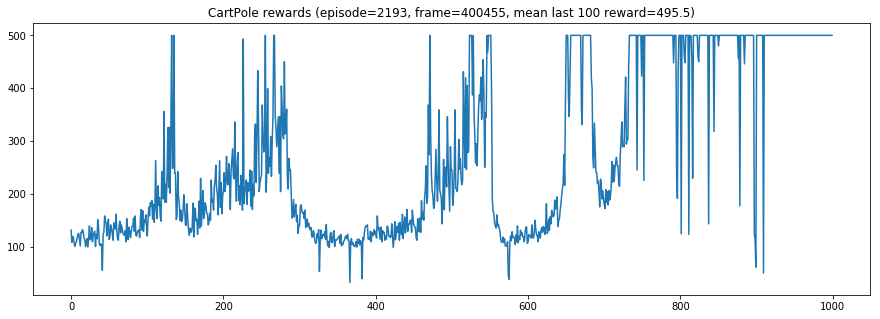

done.


In [4]:
if '__main__' == __name__:
#    signal.signal(signal.SIGHUP, handle_sighup)

    args = parse_args()
    print(args)
    os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(x) for x in args.gpu)
    args.num_steps = 5

    USE_CUDA = t.cuda.is_available()
    device = t.device('cuda' if USE_CUDA else 'cpu')
    if USE_CUDA:
        print(f'Using CUDA device: {t.cuda.get_device_name(device)}')

    env = gym.make(ENV_NAME + '-v1')
    models = Models(
        env.observation_space.shape[0],
        env.action_space.n,
        args.hidden_size
    )
    models = models.to(device)
    opt = t.optim.Adam(models.parameters(), lr=args.lrate)

    gamma = 0.99
    all_rewards = collections.deque(maxlen=1000)
    rewards_mean = 0
    frame = 0
    progress = tqdm(range(10000))
    for episode in progress:
        state, done = env.reset(), False
        all_rewards.append(0)

        while not done:
            entropy = 0

            log_probs = t.empty(args.num_steps, dtype=t.float, device=device)
            values = t.empty(args.num_steps, dtype=t.float, device=device)
            rewards = t.empty(args.num_steps, dtype=t.float, device=device)
            masks = t.empty(args.num_steps, dtype=t.float, device=device)
            returns = t.empty(args.num_steps, dtype=t.float, device=device)
            
            for step in range(args.num_steps):
                frame += 1
                s = t.FloatTensor(state).unsqueeze(0).to(device)
                dist, value = models(s)
                action = dist.sample()
                state, reward, done, info = env.step(action.item())

                entropy += dist.entropy().mean() # -(logits*probs).sum(-1).mean()
                
                log_probs[step] = dist.log_prob(action) # ~ logits[action]
                values[step] = value
                rewards[step] = reward
                masks[step] = done

                all_rewards[-1] += reward

            s = t.FloatTensor(state).unsqueeze(0).to(device)
            _, R = models(s)
            for idx in reversed(range(args.num_steps)):
                R = rewards[idx] + gamma * R * (1 - masks[idx])
                returns[idx] = R

            advantage = returns.detach() - values

            actor_loss = -(log_probs * advantage.detach()).mean()
            critic_loss = advantage.pow(2).mean()

            loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

            opt.zero_grad()
            loss.backward()
            opt.step()

        rewards_mean = np.array(all_rewards)[-100:].mean()
        progress.set_description_str(f'mean 100 rewards: {rewards_mean}')
        if rewards_mean > 495:
            break
        
        if (episode + 1) % 500 == 0:
            plot_state()

    plot_state()
    print('done.')